In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

### Setup - Preprocessed Data 
randomly split dataset into train and test set <br>
by using `pandas` and `sklearn.model_selection`

In [2]:
data = pd.read_csv("winequalityred.csv", sep=";")
y = ["quality"]
x = data.drop(y, axis=1).columns.values

print("features: ", x)
print("target: ", y)
print("data shape: ", data.shape)
data.head(3)

features:  ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol']
target:  ['quality']
data shape:  (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [3]:
kf = KFold(shuffle=True, n_splits=5)
for trainIdx, testIdx in kf.split(data):
    X_train, X_test = data[x].iloc[trainIdx], data[x].iloc[testIdx]
    y_train, y_test = data[y].iloc[trainIdx], data[y].iloc[testIdx]

In [4]:
print(X_train.shape, y_train.shape)
pd.concat([X_train.head(3), y_train.head(3)], axis=1)

(1280, 11) (1280, 1)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [5]:
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,8.335312,0.525844,0.270695,2.527188,0.087753,15.767188,46.172266,0.996752,3.308023,0.658180,10.406823
std,1.715610,0.179366,0.194513,1.414204,0.047886,10.556676,33.046172,0.001870,0.155782,0.170643,1.047701
min,4.700000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.370000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995660,3.200000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,13.000000,37.000000,0.996755,3.310000,0.620000,10.100000
75%,9.200000,0.635000,0.420000,2.600000,0.091000,21.000000,62.000000,0.997830,3.400000,0.730000,11.016667
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


In [6]:
print(X_test.shape, y_test.shape)
pd.concat([X_test.head(3), y_test.head(3)], axis=1)

(319, 11) (319, 1)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
13,7.8,0.61,0.29,1.6,0.114,9.0,29.0,0.9974,3.26,1.56,9.1,5
23,8.5,0.49,0.11,2.3,0.084,9.0,67.0,0.9968,3.17,0.53,9.4,5


### Regression equations and functions
1. adding intercept
2. the equation for a the linear model that predicts y from X
3. the equation for computing the Residual Sum of Squares (RSS) for the linear model

by using `pandas` and `numpy`

In [7]:
def predict(beta, X):
    if isinstance(beta, (pd.DataFrame, pd.Series)):
        beta = beta.values
    
    if isinstance(X, (pd.DataFrame, pd.Series)):
        index = X.index.values
        X = X.values
    
    if beta.shape[0] - X.shape[1] == 1:
        X = np.concatenate([np.ones(shape=(X.shape[0], 1)), X], axis=1)
    
    return pd.DataFrame(np.matmul(X, beta), index=index, columns=["y_hat"])


def RSS(beta, X, y):
    tmp = pd.concat([y, predict(beta, X)], axis=1)
    
    if pd.isnull(tmp).any(axis=1).sum():
        raise ValueError("y and y_hat indexes are mismatched")
        
    return tmp.apply(lambda s: (s[0] - s[1])**2, axis=1).sum()

### Training Models
by using `pandas` and `scipy.optimize`

In [8]:
beta = np.random.normal(0, 1, (X_train.shape[1] + 1, 1))
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train))
beta_hat = opt.x

In [9]:
beta_hat

array([ 2.70642827e+01,  3.96459340e-02, -1.11543978e+00, -2.39561802e-01,
        2.57632166e-02, -1.86784461e+00,  1.77171233e-03, -3.03120795e-03,
       -2.31606906e+01, -3.73597585e-01,  9.51341691e-01,  2.69295509e-01])

In [10]:
RSS(beta_hat, X_train, y_train)

548.0476221278324

### Question 1

1. What are the qualitative results from your model? <br>
2. Which features seem to be most important? <br>
3. Do you think that the magnitude of the features in X may affect the results <br>
(for example, the average total sulfur dioxide across all wines is 46.47, <br>
 but the average chlorides is only 0.087).

##### Ans:
<div class="alert alert-block alert-info">
1. my qualitative results show that density is the most significant feature, which has a negative relation with wine quality(y) <br>
2. density (with coefficient: -23.161) <br>
3. the magnitude (mean) of the features does not affect the coefficient, but the standard deviation of the features does. The density has the smallest standard deviation, and get the most significant coefficient. The chlorides has the second smallest standard deviation, and get the second significant coefficient. Hence, the magnitude of the features in X does not affect the results. </div>

In [11]:
pd.Series(beta_hat, index=["intercept"] + X_train.columns.values.tolist())\
    .round(3)\
    .sort_values()

density                -23.161
chlorides               -1.868
volatile acidity        -1.115
pH                      -0.374
citric acid             -0.240
total sulfur dioxide    -0.003
free sulfur dioxide      0.002
residual sugar           0.026
fixed acidity            0.040
alcohol                  0.269
sulphates                0.951
intercept               27.064
dtype: float64

<BarContainer object of 11 artists>

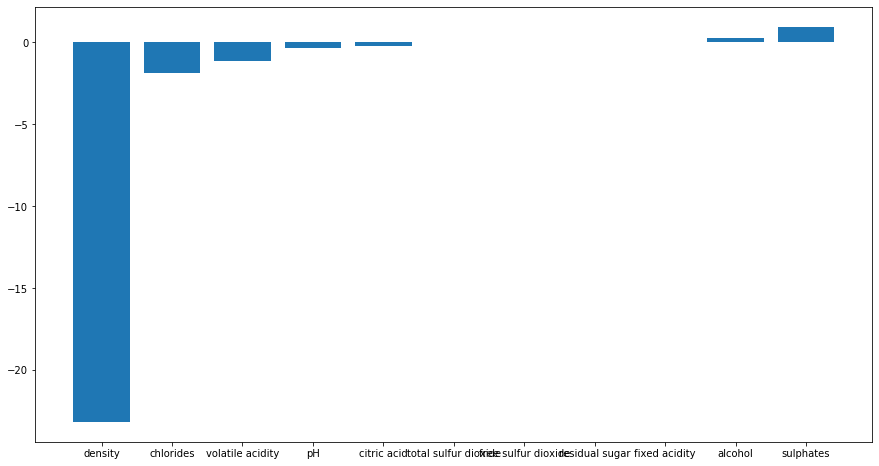

In [12]:
plt.figure(figsize=(15, 8))
plt.bar(X_train.columns[np.argsort(beta_hat[1:])], np.sort(beta_hat[1:]), align="center")

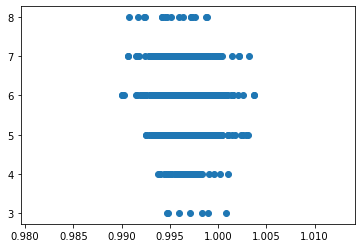

In [13]:
plt.scatter(X_train["density"], y_train)

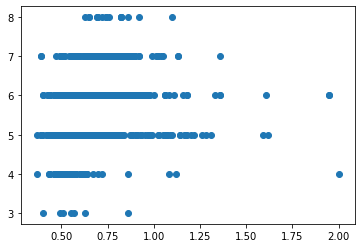

In [14]:
plt.scatter(X_train["sulphates"], y_train)

In [38]:
X_train.describe().loc['std'].sort_values()

density                  0.001870
chlorides                0.047886
pH                       0.155782
sulphates                0.170643
volatile acidity         0.179366
citric acid              0.194513
alcohol                  1.047701
residual sugar           1.414204
fixed acidity            1.715610
free sulfur dioxide     10.556676
total sulfur dioxide    33.046172
Name: std, dtype: float64

4. How well does your model fit? <br>
5. You should be able to measure the goodness of fit, RSS, on both the training data and the test data, but only report the results on the test data. <br>

In Machine Learning we almost always only care about<br> 
how well the model fits on data that has not been used to fit the model, <br>
because we need to use the model in the future, not the past. <br>
Therefore, we only report performance with holdout data, or test data.

In [15]:
def r_square(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("length mismatched")
    
    tmp = pd.concat([y_true, y_pred], axis=1)
    tmp.columns = ["y_true", "y_pred"]
    ss_res = sum((tmp["y_true"] - tmp["y_pred"])**2)
    ss_tot = sum((tmp["y_true"] - tmp["y_true"].mean())**2)
    return 1 - ss_res/ss_tot

##### Ans:
<div class="alert alert-block alert-info">
this is the model performance on testing set</div>

In [24]:
print("Model Performance in the Test Set: ")
print("RSS: ", RSS(beta_hat, X_test, y_test))
print("R^2: ", r_square(y_test, predict(beta_hat, X_test)))

Model Performance in the Test Set: 
RSS:  119.63139931822634
R^2:  0.3673758971136859


6. Does the end result or RSS change if you try different initial values of β? <br>
7. What happens if you change the magnitude of the initial β?<br>
8. Does the choice of solver method change the end result or RSS? 

##### Ans
<div class="alert alert-block alert-info">
it does not change a lot when we try different init value, the magnitude of beta, or the solver. <br>
it always trains a similar model.</div>

In [17]:
beta = np.random.normal(0, 1, (X_train.shape[1] + 1, 1))
print("new init beta: ", beta.reshape(1, -1)[0], "\n")
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train))
new_beta_hat = opt.x
print("the diff between new beta hat and beta hat", new_beta_hat - beta_hat, "\n")
print("new RSS in training set: ", RSS(new_beta_hat, X_train, y_train))
print("new RSS in testing set: ", RSS(new_beta_hat, X_test, y_test))

new init beta:  [ 1.10420058 -0.35379614 -0.453316   -1.82541366  0.34047096 -0.6333331
  0.78405788 -0.52708907  0.57052233  0.09693517  0.58494378  0.17473812] 

the diff between new beta hat and beta hat [ 1.16403851e-03  1.32896984e-06  2.78367295e-07 -6.65733391e-07
  4.84998033e-07  9.56629131e-06 -1.27194356e-08  6.57003191e-09
 -1.19881844e-03  8.39828987e-06  9.20726259e-07 -1.02918636e-06] 

new RSS in training set:  548.0476221290485
new RSS in testing set:  119.63141161718633


In [19]:
beta = np.random.normal(100, 10, (X_train.shape[1] + 1, 1))
print("new init beta: ", beta.reshape(1, -1)[0], "\n")
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train))
new_beta_hat = opt.x
print("the diff between new beta hat and beta hat", new_beta_hat - beta_hat, "\n")
print("new RSS in training set: ", RSS(new_beta_hat, X_train, y_train))
print("new RSS in testing set: ", RSS(new_beta_hat, X_test, y_test))

new init beta:  [102.75407749  95.90284318 107.77577079 109.0888861  115.71425688
 109.60428333 101.59462502 101.39922721  82.98517152 100.17813996
  92.20126406 103.92102335] 

the diff between new beta hat and beta hat [-2.77843986e-03 -2.48830390e-06 -1.90837347e-06  7.35797740e-07
 -1.17469170e-06 -9.06802000e-06  2.00363906e-08  1.76821632e-10
  2.82356057e-03 -1.10334422e-05 -3.00064587e-06  2.65986255e-06] 

new RSS in training set:  548.0476221302656
new RSS in testing set:  119.63137271534337


In [20]:
beta = np.random.normal(0, 1, (X_train.shape[1] + 1, 1))
print("new init beta: ", beta.reshape(1, -1)[0], "\n")
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train), method="Powell")
new_beta_hat = opt.x
print("the diff between new beta hat and beta hat", new_beta_hat - beta_hat, "\n")
print("new RSS in training set: ", RSS(new_beta_hat, X_train, y_train))
print("new RSS in testing set: ", RSS(new_beta_hat, X_test, y_test))

new init beta:  [ 0.07732606 -2.47321442 -0.05985959  0.17032706 -0.17635043 -1.39297713
 -1.23478964 -1.0518297   0.29080532  0.28203021  1.46501473  1.40534839] 

the diff between new beta hat and beta hat [ 4.45441104e+01  4.25747747e-02  3.71110287e-02  5.91222364e-03
  1.87111004e-02  8.67989653e-02 -3.16705125e-04  9.07877334e-05
 -4.54764156e+01  2.30842923e-01  6.07239951e-02 -4.31444105e-02] 

new RSS in training set:  549.5411289033791
new RSS in testing set:  120.39572176647644


### Question 2

In [25]:
def RSS(beta, X, y, penalty=None, lam=0.01):
    tmp = pd.concat([y, predict(beta, X)], axis=1)
    
    if pd.isnull(tmp).any(axis=1).sum():
        raise ValueError("y and y_hat indexes are mismatched")
        
        
    if penalty == "l1":
        penalty = lam * sum(abs(beta[1:])
                           )
    elif penalty == "l2":
        penalty = lam * sum(beta[1:]**2)
        
    else:
        penalty = 0
        
    return tmp.apply(lambda s: (s[0] - s[1])**2, axis=1).sum() + penalty

##### Ridge Regression (L2)

In [26]:
beta = np.random.normal(0, 1, (X_train.shape[1] + 1, 1))
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l2"))
beta_hat_L2 = opt.x

In [27]:
pd.DataFrame(
    np.array([beta_hat, beta_hat_L2]).T, 
    index=["intercept"] + X_train.columns.values.tolist(),
    columns=["beta_hat", "beta_hat_L2"]
).round(3)

,beta_hat,beta_hat_L2
intercept,27.064,5.905
fixed acidity,0.040,0.020
volatile acidity,-1.115,-1.134
citric acid,-0.240,-0.243
residual sugar,0.026,0.017
chlorides,-1.868,-1.899
free sulfur dioxide,0.002,0.002
total sulfur dioxide,-0.003,-0.003
density,-23.161,-1.565
pH,-0.374,-0.482


1. How does RSS on the training data change? How does RSS on the test data change?

##### Ans
<div class="alert alert-block alert-info">
Both RSS in train and test set are slightly lower. That is probably because there is no collinearity or overfitting issue in the original regression. Hence, RSS does not decrease that much.</div>

In [28]:
print("Ridge Regression Performance")
print("RSS in train set: ", RSS(beta_hat_L2, X_train, y_train))
print("RSS in test set: ", RSS(beta_hat_L2, X_test, y_test))

Ridge Regression Performance
RSS in train set:  548.3845550489718
RSS in test set:  119.52477313625242


In [29]:
print("Ridge Regression RSS in test set")
beta = np.random.normal(0, 1, (X_train.shape[1] + 1, 1))

lam = 0.001
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l2", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 0.01
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l2", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 0.1
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l2", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 1
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l2", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 10
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l2", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

Ridge Regression RSS in test set
when lambda=0.001 119.54648852766778
when lambda=0.010 119.52477532163306
when lambda=0.100 119.51194318085047
when lambda=1.000 119.5455530758368
when lambda=10.000 120.43777211171954


##### Ans
<div class="alert alert-block alert-info">
the results shows when lambda=0.1 Ridge Regression has the best performance on testing set.</div>

##### Lasso Regression (L1)

In [30]:
print("Lasso Regression RSS in test set")
beta = np.random.normal(0, 1, (X_train.shape[1] + 1, 1))

lam = 0.001
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 0.01
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 0.1
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 1
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 10
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

Lasso Regression RSS in test set
when lambda=0.001 119.62536129941725
when lambda=0.010 119.5786524555306
when lambda=0.100 119.51131800804576
when lambda=1.000 119.42492919989249
when lambda=10.000 121.04418678620505


In [33]:
lam = 1.000
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

when lambda=1.000 119.42492919989249


In [34]:
pd.Series(opt.x[1:], index=X_test.columns.values).round(3)

fixed acidity           0.020
volatile acidity       -1.127
citric acid            -0.215
residual sugar          0.015
chlorides              -1.661
free sulfur dioxide     0.002
total sulfur dioxide   -0.003
density                -0.000
pH                     -0.436
sulphates               0.879
alcohol                 0.292
dtype: float64

##### Ans
<div class="alert alert-block alert-info">
the magnitude of the features in X won't affect the results with regularization. Since regularization shrink the less informative features and expand the more informative features, so the magnitude does not affect the result with regularization.</div>